In [37]:
import numpy as np
from bokeh.plotting import figure, show
from bokeh.io import output_notebook, push_notebook
from bokeh.layouts import column, row
output_notebook()
from scipy.signal import welch
import scipy.constants as constants

Loading BokehJS ...

# Thermomechanical noise demo

First, we will numerically simulate what thermomechanical noise looks like. We will do this by first using a uncorrelated (white) force noise, Fourier transform this, apply a Harmonic oscillator response function to the (complex) transform data, and then inverse Fourier transform this: this will allow us to look at what a theoretical time trace of the random Brownian motion of an oscillator would look like. 

Note that to get good statistics on a high-Q oscillator, we need to take a LOT of samples (50 million points)! 

We will work with a mass of 1 kg, a frequency of 50 Hz, a Q of 1000. To get a high enough resolution FFT to see our peak, we will need a *super* long time trace: 100,000 seconds! 

Similar to our example from class in which a measurement of total time $T$ cannot know if there are frequency components in a signal that are smaller than $\omega_{min} \sim 1/T$, the same time trace also cannot tell the *difference* in frequencies of two different oscillations if they are closer in frequency than $\omega_{min}$: for that reason, if we want to get high frequency resolution in our FFT (many points in the spectral peak), the time trace has to be *super* long! 

Similarly, we want to have a small enough spacing in time between our points to be able to resolve our oscillations nicely. Here, we will choose a sampling rate that is 10 times higher than the oscillator frequency (10 points per full oscillation, corresponding to 5 times faster than the nyquist limit in which a sine wave would contain only two points per oscillation...). 

Those two combined leave us with a huge sample trace of 50 million points. 

In [101]:
# Sampling rate
fs = 500

# Total time trace length in seconds
T = 100000

# mechanical frequency in Hz 
f0 = 50 

# Q of resonator
Q = 1000 

# Our time vector
t = np.arange(0,T,1/fs)

# A randomly fluctuating force:
# What amplitude should I specify here? By reverse engineering
# using scipy welch to calculate the PSD, I find an average PSD 
# of 0.004 for an amplitude of 1. 
sigma = np.sqrt(4*constants.k*300*f0/2/np.pi/Q/0.004)
np.random.seed(0)
F = np.random.normal(0,sigma,len(t))

# x(t) is determined by the convolution of the fluctuating force
# with the Harmonic Oscillator transfer function
F_t = np.fft.fft(F)
f = np.fft.fftfreq(len(F), 1/fs)

# Here we can take m = 1 and F = 1: then our plot will be in meters. 
# The HO transfer (response) function 
H = f0**2 / (f0**2 - f**2 + 1j*f*f0/Q)
x_t = F_t * H

# Inverse FT. Note that x is still a real-valued function, but 
# is of imaginary type, so we have to use np.real to avoid complaints
# from matplotlib during plotting
x = np.real(np.fft.ifft(x_t))

We can now plot this too to see what the oscillations look like. We will not plot all 50 million points, Bokeh does not like that so much...but instead plot only the first 100,000. 

Warning: in this interactive plot, I recommend you use only the "drag window zoom" as the scroll zoom is very unresponsive with so many points...

In [102]:
p = figure(height=300, width=600) 
p.sizing_mode = "scale_width"
p.xaxis.axis_label = "Time (s)"
p.yaxis.axis_label = "Position (m)"
nplot = int(1e5)
p.line(t[0:nplot],x[0:nplot])
show(p)

The first interesting thing we can see is the amplitude: if we've done our calculations correctly, then the amplitude of the fluctuation of a 50 Hz, 1 kg mass spring oscillator are about 10 nm. 

Fully zoomed out, it looks like random noise, but if you zoom in a bit, you will see that on short time scale, there are what look like coherent oscillations: 

In [103]:
p = figure(height=300, width=600) 
p.sizing_mode = "scale_width"
p.xaxis.axis_label = "Time (s)"
p.yaxis.axis_label = "Position (m)"
nplot = int(1e3)
p.line(t[0:nplot],x[0:nplot])
show(p)

Why do we start to see oscillations now? The reason is that because of the high-Q of the oscillator, the oscillations you get from the random kicks from the force noise do not decay right away: in fact, a single kick will result in some small oscillation amplitude that will have a 1/e decay time of 1000 oscillations for a Q = 1000! 

What is also interesting is to plot the position and the force noise together:

In [104]:
p1 = figure(height=150, width=600) 
p1.sizing_mode = "scale_width"
p1.xaxis.axis_label = "Time (s)"
p1.yaxis.axis_label = "Position (m)"
nplot = int(1e3)
p1.line(t[0:nplot],x[0:nplot])

p2 = figure(height=150, width=600, x_range = p1.x_range) 
p2.sizing_mode = "scale_width"
p2.xaxis.axis_label = "Time (s)"
p2.yaxis.axis_label = "Force (N)"
nplot = int(1e3)
p2.line(t[0:nplot],F[0:nplot])

c = column(p1,p2)
c.sizing_mode = 'scale_width'

show(c)

Note that due to the "long memory" of the high-Q oscillator, it is difficult to correlate the deviations in the force with the amplitude of the oscillations: this is because the total amplitude is a sum of all the interfering "transients" from the different random fluctuations of the force. 

As we discussed / derived in class, if we look at the power spectral density of the position signal, we should see something that is peaked at the resonance frequency. Let's take a look!

To do this, we could take the FFT ourselves, but it can be tricky to work out what the correct scaling factors are that we need to convert the numerical FFT as calculated in python to power spectral density with the correct units...

Furthermore, we should also average this FFT in some smart way to get something that looks like a power spectral density (see demo code in homework 1). 

Fortunately, there is a nice python solution to both these problems: the `welch` function from `scipy`! 

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html

If you give it the sampling frequency, it will do all the things in the right way to calculate the power spectral density in the correct units. 

Furthermore, it allows you do averaging: in particular, the parameter `nperseg` tells you how many points it should take in the "segments" that it uses to slice up the data when it make the many separate time traces to average together. Picking `nperseg` equal to the total trace length is equivalent to no averaging. It will return two things: both the PSD it calculates, and an appropriately chosen frequency axis to match it. 

Let's take a look:

Text(0, 0.5, 'PSD Sxx (m^2/Hz)')

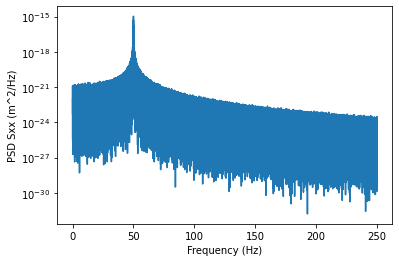

In [105]:
f_psd, Sxx = welch(x,fs,nperseg=len(x))
# I will plot this with matplotlib since bokeh cannot handle 50 million points...
plt.plot(f_psd, Sxx)
plt.yscale('log')
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD Sxx (m^2/Hz)")

Ok, this looks not too bad! But indeed pretty noisy. Let's look if we average a bit:

In [106]:
f_psd, Sxx = welch(x,fs,nperseg=len(x)//1000)

# Bokeh can handle 25000 points :)
p1 = figure(height=300, width=600, y_axis_type = 'log') 
p1.sizing_mode = "scale_width"
p1.xaxis.axis_label = "Frequency (Hz)"
p1.yaxis.axis_label = "Power spectral density Sxx (m^2/Hz)"
p1.line(f_psd[1:-2],Sxx[1:-2])
show(p1)

Finally, we will look at one more thing: the "quadratures" of the 50 Hz motion. 

Why? In the plots above of the position vs time, from the envelope we can see that the amplitude is fluctuating in time. What is harder to see is that also the *phase* of the oscillations also oscillates in time! To see this clearly, we can calculate the I and Q quadratures referenced to a 50 Hz signal and plot these as a function of time, which is done in the code below, which is a digital equivalent version of what a "lock in" amplifier does:

In [107]:
# Let's try to make quadrature plots

# First, feed the signal into a mixer, frequency shifting one of the
# +/- f0 peaks down to zero frequency (the other one gets shifted
# to 2f0)

# Why the factor of two? Of course! From 1/2(1-cos(2\omega))!
f_d = 50
x_demod = x * np.exp(-1j*f_d*2*np.pi*t)*2

# I will use a decimation filter: 

def decimate(x, n):
    end =  n * int(len(x)/n)
    return np.mean(x[:end].reshape(-1, n), 1)

N = 10
x_demod_dec = decimate(x_demod, N)
I_dec = np.real(x_demod_dec)
Q_dec = np.imag(x_demod_dec)
A_dec = np.abs(x_demod_dec)
Ph_dec = np.angle(x_demod_dec)
t_dec = decimate(t, N)

Ok, let's plot it!

In [108]:
nplot = int(1e4)

from bokeh.palettes import Category10 as col

p1 = figure(height=300, width=600) 
p1.sizing_mode = "scale_width"
p1.xaxis.axis_label = "Frequency (Hz)"
p1.yaxis.axis_label = "Power spectral density Sxx (m^2/Hz)"
p1.line(t[0:nplot*10], x[0:nplot*10], color='lightgrey', legend_label = 'x')
p1.line(t_dec[0:nplot], A_dec[0:nplot], color=col[4][0], legend_label = "Amplitude")
p1.line(t_dec[0:nplot], I_dec[0:nplot], color=col[4][1], legend_label = "I")
p1.line(t_dec[0:nplot], Q_dec[0:nplot], color=col[4][2], legend_label = "Q")

show(p1)

The blue line shows the amplitude, the grey line the actual oscillations, the orange the in-phase quadrature, and the orange "out of phase" quadrature. If you zoom in a bit, you can see more clearly how the amplitude (which is "quadrature sum" of I and Q: $A = \sqrt{I^2 + Q^2}$ follows the amplitude of the oscillations, and if you look very carefully, you might be able to see how the phase of the oscillations changes when the signal goes from one quadrature to another :)

In [109]:
nplot = int(200)

from bokeh.palettes import Category10 as col

p1 = figure(height=300, width=600) 
p1.sizing_mode = "scale_width"
p1.xaxis.axis_label = "Frequency (Hz)"
p1.yaxis.axis_label = "x / A / I / Q (m)"
p1.line(t[0:nplot*10], x[0:nplot*10], color='lightgrey', legend_label = 'x')
p1.line(t_dec[0:nplot], A_dec[0:nplot], color=col[4][0], legend_label = "Amplitude")
p1.line(t_dec[0:nplot], I_dec[0:nplot], color=col[4][1], legend_label = "I")
p1.line(t_dec[0:nplot], Q_dec[0:nplot], color=col[4][2], legend_label = "Q")

show(p1)